## **Nederlandse Loodswezen**

In deze notebook wordt een data-analyse voor de Nederlandse Loodswezen uitgevoerd. Onderzoek wordt gedaan naar de betrouwbaarheid van de **agenten**, het **soort schip** en de **vertreklocatie**, aan de hand van het **aantal mutaties** in **registratietijden**. Om te beginnen een korte uitleg over de data inclusief variabelen die te onderzoeken zijn. 

Er zijn twee databestanden, waarin verschillende variabelen te vinden zijn. In het bestand *mutaties.csv* zijn de wijzigingen van de Estimated Time of Departure (ETD) voor elke reis te vinden. Voor iedere ETD vindt een registratie plaats, van iedere registratie wordt ook de tijd gerapporteerd. De registratietijd is dus het moment dat de agent de ETD registreert. De ETD is de voorspelde vertrektijd, ook wel de laatst bekende tijd van het schip. Bij herhaaldelijke registraties vertrekt het schip dus op een ander moment dan in eerste instantie was aangegeven. Een **mutatie** staat dus voor een wijziging van de ETD, dit is soms een aantal keer gedaan (meerdere mutaties) en soms maar een enkele keer.

In het tweede databestand *historical_data.csv* zijn variabelen te vinden als de agent, het soort schip, de vertreklocatie en de tijd aan boord. Zoals eerder al benoemd, kunnen we van deze variabelen de betrouwbaarheid onderzoeken aan de hand het aantal mutaties dat wordt gemaakt. 

**Dus wat gaan we nu eigenlijk precies onderzoeken aan de hand van deze data?**

In deze notebook wordt onderzocht of we de betrouwbaarheid van het gedrag van een Agent, Soort schip, of Vertreklocatie kunnen meten. Is het bijvoorbeeld zo, dat een agent betrouwbaarder is als hij vaak de ETD-update, of is hij juist minder betrouwbaar als hij vaak de ETD-update. Het kan zo zijn, dat een agent zijn eerste reis aanmaakt (eerste registratie/ETD) en daarna telkens een update gaat sturen. Sommige agenten zullen dit vaak doen, en dus accuraat zijn met hun registraties. Kortom, het aantal mutaties in de ETD kan worden gebruikt om te bepalen hoe betrouwbaar het gedrag van de agent is. Voor het soort schip, kan je je ook voorstellen dat sommige schepen bijvoorbeeld vaker vertraging hebben en daardoor ook weer vaker wijzigingen (mutaties) doorgeven. Hiernaast kunnen we nog onderzoeken of het aantal mutaties dat wordt doorgegeven is toegenomen in de afgelopen jaren. Om dit doen, vergelijken we het aantal mutaties dat plaatsvond in 2005 met het aantal mutaties dat plaatsvond in 2018. Voor verdere analyses wordt de data uit 2018 gebruikt, gezien dit de meest recente data in dit bestand is. 

Voor deze data-analyse maken we een aantal nieuwe variabelen aan:

##### *Nieuwe variabelen:*
- Verschil tussen de eerste en laatste registratietijd 
- Verschil tussen de eerste en de laatst opgegeven ETD-tijd
- Verschil tussen de laatste registratietijd en de laatste ETD-tijd
- Verschil tussen de laatste ETD-tijd en de tijd aan boord
- Aantal mutaties per reis 
- Vertraagd vs. niet vertraagd (ETD-verschil < 2.5 uur)
- Op tijd gemeld vs. Laat gemeld (verschil registratie en ETD < 2.5 uur)




Om te beginnen gaan we aan de slag met het mutaties.csv bestand.

In [1]:
# Importeer data analyse libraries
import pandas as pd
import numpy as np

# Lees het mutatie bestand in
mutaties = pd.read_csv('Loodswezen/mutaties.csv', sep = ';')

# verander registartietijd naar datetime object
mutaties['registratietijd'] = pd.to_datetime(mutaties['registratietijd'], errors = 'coerce')
# verander etdtijd naar datetime object
mutaties['etdtijd']         = pd.to_datetime(mutaties['etdtijd'], errors = 'coerce')

mutaties.head()

,id,reisnummer,registratietijd,etdtijd
0,39363,R2005-074208,2005-11-08 20:01:00.757,2005-12-08 23:00:00
1,39307,R2005-076417,2005-11-18 09:25:14.037,2005-11-30 14:30:00
2,39555,R2005-076421,2005-11-18 09:31:04.350,2005-11-30 22:00:00
3,39219,R2005-076428,2005-11-18 09:38:52.283,2005-11-30 16:00:00
4,39221,R2005-076433,2005-11-18 09:43:08.657,2005-12-01 07:20:00


*Laten we om te beginnen eens kijken naar het aantal mutaties dat wordt gemaakt per reis: We zijn nu geïnteresseerd in het verschil tussen het aantal mutaties wat gemaakt werd in het verleden vs. het heden (2005 vs. 2018). Klopt het dat de agenten over de jaren heen meer gebruik zijn gaan maken van de technologie om updates te sturen betreffende de ETD?*

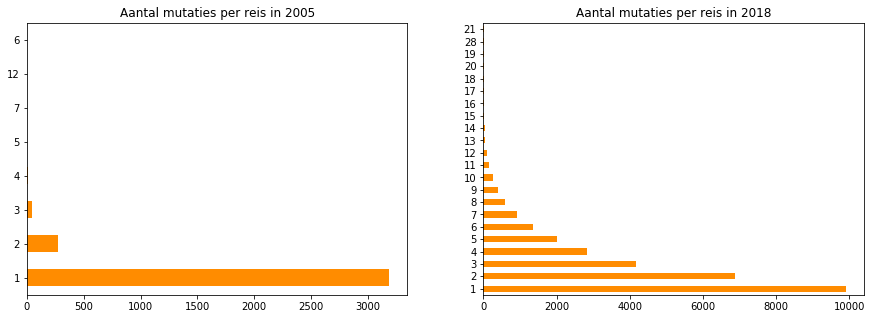

In [3]:
# Tel het aantal aantal mutaties per reis
# Vergelijk 2005 met 2018

# 2005
data_2005      = mutaties[mutaties['reisnummer'].str.contains("R2005")]
count_2005     = data_2005.groupby('reisnummer')['registratietijd'].count().reset_index()
count_2005     = count_2005.rename(columns = {"reisnummer": "Reisnummer", 'registratietijd': 'Mutaties'})

# 2018
data_2018      = mutaties[mutaties['reisnummer'].str.contains("R2018")]
count_2018     = data_2018.groupby('reisnummer')['registratietijd'].count().reset_index()
count_2018     = count_2018.rename(columns = {"reisnummer": "Reisnummer", 'registratietijd': 'Mutaties'})

# Welk aantal mutaties komt het meeste voor 
import matplotlib.pyplot as plt

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))
# Eerste plot
count_2005['Mutaties'].value_counts().head(30).plot(kind='barh', color = 'darkorange', ax = axes[0])
axes[0].set_title('Aantal mutaties per reis in 2005')
# Tweede plot
count_2018['Mutaties'].value_counts().head(30).plot(kind='barh', color = 'darkorange', ax = axes[1])
axes[1].set_title('Aantal mutaties per reis in 2018')
# Voeg labels toe
plt.show();

*Op het oog lijkt er duidelijk een verschil te zijn tussen het aantal mutaties in 2005 en 2018. In 2018 werden deze met een stuk meer regelmaat gemaakt dan in 2005. Om te kijken of dit verschil significant is, voeren we een t-test uit. Hieruit resulteert een p-value van 0.0, hieruit kunnen we met concluderen dat er een significant verschil is tussen het aantal mutaties in 2005 vs. het aantal mutaties in 2018.*

In [4]:
from scipy import stats

ttest = stats.ttest_ind(count_2018['Mutaties'], count_2005['Mutaties'], equal_var = False)
ttest.pvalue

0.0

*Zoals eerder benoemd, gebruiken we voor de verdere analyse de data uit 2018. Nu zullen een aantal nieuwe variabelen worden aangemaakt en toegevoegd aan de huidige dataframe:*

- Verschil tussen de eerste en de laatste registratietijd (in seconden)
- Verschil tussen de eerste en laatste ETD-tijd (in seconden)
- Aantal mutaties per reis
- Verschil tussen de laatste registratietijd en de laatste ETD-tijd

In [5]:
# De reizen die hun registratietijd meer dan 1 keer hebben ingevoerd. 
dubbel_reg                   = data_2018[data_2018.duplicated(['reisnummer'], keep=False)]
dubbel_reg                   = dubbel_reg.sort_values(by = ['reisnummer','registratietijd'])


# Tijdverschil in registartietijd binnen iedere reis (in seconden)
data_2018                    = data_2018.sort_values(by = ['reisnummer','registratietijd'])
data_2018['reg_diff']        = data_2018.groupby('reisnummer')['registratietijd'].diff().dt.seconds.fillna(0)

# Tijdverschil in etd's binnen iedere reis (in seconden)
data_2018['etd_diff']        = data_2018.groupby('reisnummer')['etdtijd'].diff().dt.seconds.fillna(0)

# Verbeter namen van kolommen om later samen te kunnen voegen met Historische data
data_2018                    = data_2018.rename(columns = {"id": "ID", "reisnummer": "Reisnummer"})

# Een mogelijkheid voor het nemen van de sum van de time_diff per reisnummer
# Op deze manier een totaal verschil tussen eerste en laatste registratie
df                           = data_2018.sort_values(by = ['Reisnummer','registratietijd']).groupby(['Reisnummer']).agg(
                                                        {'ID': 'first', 'registratietijd': 'last', 'etdtijd': 'last',
                                                         'reg_diff': 'sum','etd_diff': 'sum'})

# Zorg ervoor dat reisnummer weer een kolom is:
df.index.name                = 'Reisnummer'
df.reset_index(inplace=True)

# Voeg aantal mutaties toe aan dataframe
mutatie_data                 = pd.merge(df, count_2018, on = ['Reisnummer'])

# Als laatste voegen we het tijd verschil tussen de etd tijd en de registratietijd toe:
# bereken verschil tussen etd tijd en registratietijd
mutatie_data['diff_reg_etd'] = (mutatie_data['etdtijd'] - mutatie_data['registratietijd'])
mutatie_data['diff_reg_etd'] = mutatie_data['diff_reg_etd'].dt.seconds.fillna(0)

mutatie_data.head()

,Reisnummer,ID,registratietijd,etdtijd,reg_diff,etd_diff,Mutaties,diff_reg_etd
0,R2018-000003,1632322,2018-01-07 20:06:45.767,2018-01-07 22:15:00,137775.0,252960.0,8,7694
1,R2018-000004,1632324,2018-01-02 08:57:56.970,2018-01-02 11:00:00,5728.0,54000.0,2,7323
2,R2018-000006,1632326,2018-01-01 18:28:05.543,2018-01-01 20:30:00,31420.0,9000.0,2,7314
3,R2018-000007,1632327,2018-01-01 12:38:21.433,2018-01-01 14:45:00,10356.0,900.0,2,7598
4,R2018-000015,1632335,2018-01-01 10:52:25.307,2018-01-01 14:00:00,0.0,0.0,1,11254


*Nu ook de Historical data output, deze bevat extra variabelen waarvan we de betrouwbaarheid willen meten. Deze dataset wordt gelijk wat opgeschoond, zoals het verwijderen van lege variabelen, dubbele kolommen en het veranderen van kolom namen. Ook worden er nog een aantal nieuwe variabelen aangemaakt:*

- Verschil tussen de laatste geregistreerde ETD-tijd en de tijd aan boord
- Optijd_gemeld vs. laat_gemeld (verschil tussen de registratietijd en ETD > 2,5 uur, dan was de registratie op tijd gemeld)
- Vertraagd vs niet_vertraagd (verschil tussen de eerste en de laatste ETD > 2,5 uur, dan was de reis vertraagd)

In [6]:
# Lees de historische data
historical              = pd.read_csv('Loodswezen/Historical_data.csv', sep = ';', encoding = 'latin-1', low_memory = False)

# Selecteerd data uit 2018 en outbound of shifting
historical_2018         = historical[historical['Reisnummer'].str.contains("R2018")]
historical_2018         = historical[historical['Soort reis'].str.contains("outbound|shifting")]


# De twee dataframes samenvoegen op basis van het reisnummer
data                    = pd.merge(mutatie_data, historical_2018, on = ['Reisnummer', 'ID'])

# Het lijkt erop dat Naam schip een lege variabele is, deze kunnen we dus verwijderen
data.iloc[:, [8]].isnull().sum()

# We latem dus 'Naam schip' vallen
data                    = data.drop(['Naam schip'], axis = 1)

# Aangezien etdtijd en ETA/ETD identiek zijn laten we etdtijd kolom vallen
data                    = data.drop(['ETA/ETD'], axis = 1)

# De ID is in principe ook niet interessant
data                    = data.drop(['ID'], axis = 1)
 
# Laten we ook wat namen veranderen voor het overzicht
data                    = data.rename(columns = {"registratietijd": "Registratietijd", "etdtijd": "ETD"})

# Drop rijen waar tijd aan boord niet is aangegeven
data.dropna(subset      = ["Tijd aan boord"], inplace=True)

# Organiseer kolommen netjes
data                    = data[['Reisnummer', 'Registratietijd', 'ETD', 'Tijd aan boord', 'reg_diff', 'etd_diff', 
                               'diff_reg_etd','Mutaties', 'Soort schip', 'Aankomst/vertreklocatie', 'Agent', 'Soort reis']]

# verander Tijd aan boord naar datetime object
data['Tijd aan boord']  = pd.to_datetime(data['Tijd aan boord'])

# verander ETD naar datetime object
data['ETD']             = pd.to_datetime(data['ETD'])

# bereken verschil tussen etd tijd en tijd aan boord
data['diff_tijdab_etd'] = (data['Tijd aan boord'] - data['ETD'])
data['diff_tijdab_etd'] = data['diff_tijdab_etd'].dt.seconds.fillna(0)

# Maak variabele optijd_gemeld vs. laat_gemeld als diff_reg_etd groter is dan 9000 (2,5 uur)
data['Registratie']      = np.where(data['diff_reg_etd'] >= 9000, 'optijd_gemeld', 'laat_gemeld')

# Maak variabele vertraagd vs. niet_vertraagd als etd_diff groter is dan 9000 (2,5 uur)
data['Vertraging']      = np.where(data['etd_diff'] >= 9000, 'vertraagd', 'niet_vertraagd')

# plaats nieuwe variabele op de juiste plek
mid                     = data['diff_tijdab_etd']
data.drop(labels        =['diff_tijdab_etd'], axis=1, inplace = True)
data.insert(4, 'diff_tijdab_etd', mid)

# De data ziet er nu als volgt uit:
data.head()

,Reisnummer,Registratietijd,ETD,Tijd aan boord,diff_tijdab_etd,reg_diff,etd_diff,diff_reg_etd,Mutaties,Soort schip,Aankomst/vertreklocatie,Agent,Soort reis,Registratie,Vertraging
0,R2018-000003,2018-01-07 20:06:45.767,2018-01-07 22:15:00,2018-01-07 22:15:00,0,137775.0,252960.0,7694,8,Chemical/Oil Products Tanker,G4110 3E PET VOPAK 2,STEDER GROUP AGENCIES B.V,outbound,laat_gemeld,vertraagd
1,R2018-000004,2018-01-02 08:57:56.970,2018-01-02 11:00:00,2018-01-02 11:00:00,0,5728.0,54000.0,7323,2,Chemical/Oil Products Tanker,G4205 CHEMIEH STOLT STG,S5 NE BV,outbound,laat_gemeld,vertraagd
2,R2018-000006,2018-01-01 18:28:05.543,2018-01-01 20:30:00,2018-01-01 20:25:00,86100,31420.0,9000.0,7314,2,LPG Tanker,G5601 7E PET LYONDELL ZUID,GAC NETHERLANDS LIMITED,outbound,laat_gemeld,vertraagd
3,R2018-000007,2018-01-01 12:38:21.433,2018-01-01 14:45:00,2018-01-01 14:30:00,85500,10356.0,900.0,7598,2,Oil Products Tanker,G4047 3E PET ODFJELL KADE H,GAC NETHERLANDS LIMITED,outbound,laat_gemeld,niet_vertraagd
4,R2018-000015,2018-01-01 10:52:25.307,2018-01-01 14:00:00,2018-01-01 14:00:00,0,0.0,0.0,11254,1,LNG Tanker,G9850 YUKONH GATE,VOPAK AGENCIES ROTTERDAM B.V.,outbound,optijd_gemeld,niet_vertraagd


*De data bestaat nu dus uit een aantal continue variabelen en een aantal categorische variabelen. Correlaties tussen categorische en continue variabelen zijn niet mogelijk, maar we kunnen wel direct kijken naar correlaties tussen de continue variabelen:*

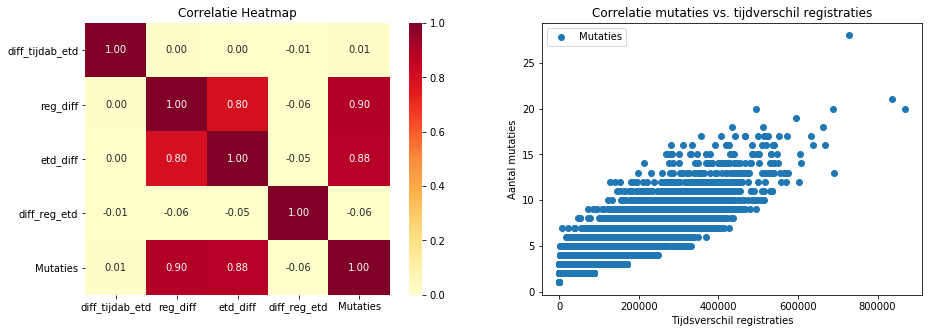

In [7]:
# Selecteer enkel de continue variabelen
numeric_cols = data.select_dtypes(include=[np.number]).columns
cont         = data[numeric_cols]

# import seaborn
import seaborn as sns

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))
# correlatie heatmap
sns.heatmap(cont.corr(), cmap='YlOrRd', annot=True, fmt='.2f', vmin=0, ax = axes[0])
axes[0].set_title('Correlatie Heatmap')

# correlatie mutatie vs. reg_diff
cont.plot(x = 'reg_diff', y = 'Mutaties', style='o', ax = axes[1]) 
axes[1].set_title('Correlatie mutaties vs. tijdverschil registraties')
plt.xlabel('Tijdsverschil registraties')  
plt.ylabel('Aantal mutaties')

plt.show();

*Zo te zien zijn er een aantal hele sterke correlaties te vinden. De hoogste correlatie is tussen het aantal mutaties en het verschil tussen de eerste en laatste registratie (c = 0.90). Ook, is er een hoge correlatie tussen het verschil in ETD's en het aantal mutaties (c = 0.88) en het verschil in registraties en ETD's (c = .80).*

*Om verdere analyses te kunnen doen is het van belang eerst de data te standaardiseren. Dit wordt gedaan aan de hand van Z-scores: Een Z-score geeft aan hoeveel standaarddeviaties een observatie van het gemiddelde af zit. Je krijgt dus je plek ten opzichte van het gemiddelde, uitgedrukt in een standaardmaat. Dit heeft als voordeel dat je direct kunt zien hoe goed iets of iemand scoort ten opzichte van de rest. Aan de hand van deze standaardisatie, kunnen we corrigeren voor ongelijke verdelingen tussen groepen, aangezien we alles op dezelfde schaal plaatsen.*

In [8]:
from scipy.stats import zscore

# Selecteer alle numerieke kolommen
numeric_cols          = data.select_dtypes(include=[np.number]).columns

# Bereken z-scores voor deze kolommen
z_scores              = data[numeric_cols].apply(zscore)   

### **Continue variabelen:**

*Eens kijken naar de accuraatheid van een simpele lineaire regressie aan de hand van enkel de continue variabelen. Als afhankelijke variabele gebruiken we het aantal mutaties. We willen namelijk onderzoeken of we aan de hand van verscheidene onafhankelijke variabelen (e.g., soort schip, agent, verschil tussen ETD's) kunnen voorspellen hoe vaak er wordt gemuteerd.*

In [9]:
from sklearn import metrics
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split

# De afhankelijke variabele
y                                = z_scores['Mutaties']

# De onafhankelijke variabelen
X                                = z_scores[['reg_diff', 'etd_diff', 'diff_tijdab_etd', 'diff_reg_etd']]

# Split de data in train en test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

# Linear regression
regressor                        = LinearRegression()  
regressor.fit(X_train, y_train) #training het algoritme

# Haal de coefficienten op
coeff_df                         = pd.DataFrame(regressor.coef_, X_test.columns, columns=['Coefficient'])  

# Maak voorspellingen
y_pred                           = regressor.predict(X_test)

# Print r2
print('R2:', metrics.r2_score(y_test, y_pred)) 
print(coeff_df)

R2: 0.8849425500622241
                 Coefficient
reg_diff            0.529929
etd_diff            0.459969
diff_tijdab_etd     0.003262
diff_reg_etd       -0.005721


*Uit deze lineaire regressie kunnen we concluderen dat het verschil tussen de ETD's en het verschil tussen de eerste en laatste registratie het meeste bijdragen aan het model. De R2 is 0.88, wat een erg goed resultaat is! Want waar de staat de R2 nou eigenlijk voor?*

*R-squared is een "goodness-of-fit" maat geschikt voor lineaire regressie modellen. Deze statistiek geeft een indicatie van het percentage variantie in de afhankelijke variabele (Mutaties) die correct verklaard wordt door de onafhankelijke variabelen. R-squared meet de kracht van de relatie tussen het model en de afhankelijke variabele op een gunstige schaal (0-100%). Dit maakt deze statistische maat zeer geschikt voor interpretatie. Aan de hand van deze regressie analyse kunnen we dus concluderen dat 88% van de variantie in de Mutaties verklaard kan worden aan de hand van het model.*

### **Categorische variabelen:**

*Ook zijn we geïnteresseerd in de relatie tussen de categorische variabelen en het aantal mutaties. Daarom zullen we ons hier nog verder in verdiepen. Om te beginnen kunnen we eens kijken hoeveel categorieën er in iedere variabele zitten:*

In [10]:
print('Aantal categorien soort schip:', len(data['Soort schip'].unique()))
print('Aantal categorien vertreklocatie:', len(data['Aankomst/vertreklocatie'].unique()))
print('Aantal categorien agent:', len(data['Agent'].unique()))

Aantal categorien soort schip: 105
Aantal categorien vertreklocatie: 793
Aantal categorien agent: 125


*Om lineare regressie uit te kunnen voeren met categorische variabelen, maken we dummie variabelen aan:*

In [24]:
# creeer dummie variabelen voor de categorien
dummie_sc = pd.get_dummies(data["Soort schip"], prefix = 'schip', drop_first = True)
dummie_av = pd.get_dummies(data["Aankomst/vertreklocatie"], prefix = 'locatie', drop_first = True)
dummie_ag = pd.get_dummies(data["Agent"], prefix = 'agent', drop_first = True)
dummie_ot = pd.get_dummies(data["Registratie"], drop_first = True)
dummie_ov = pd.get_dummies(data["Vertraging"], drop_first = True)

# totaal dataframe
dats      = [data, dummie_sc, dummie_av, dummie_ag, dummie_ot, dummie_ov]
tot       = pd.concat(dats, axis = 1)

*Laten we een lineaire regressie doen voor alle vijf de categorische variabelen. Kunnen we aan de hand van deze variabele tot zekere mate het aantal mutaties voorspellen?*

In [12]:
from sklearn import metrics
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split 

# De afhankelijke variabele
y                                = z_scores['Mutaties']

# De onafhankelijke variabelen
X                                = [dummie_sc, dummie_av, dummie_ag, dummie_ot, dummie_ov]

# Lege variabele
acc                              = []

for onafhankelijk in X:
    # Split de data in train en test
    X_train, X_test, y_train, y_test = train_test_split(onafhankelijk, y, test_size=0.2, random_state=0)
    
    # Linear regression
    regressor                        = LinearRegression()
    # train het algoritme
    regressor.fit(X_train, y_train) 

    # Maak voorspellingen
    y_pred                           = regressor.predict(X_test)
    acc.append(y_pred)
    
print('R-squared linear regression Soort schip:', metrics.r2_score(y_test, acc[0]))
print('R-squared linear regression Vertreklocatie:', metrics.r2_score(y_test, acc[1]))
print('R-squared linear regression Agent:', metrics.r2_score(y_test, acc[2]))
print('R-squared linear regression optijd_gemeld vs. laat_gemeld:', metrics.r2_score(y_test, acc[3]))
print('R-squared linear regression vertraagd vs. niet_vertraagd:', metrics.r2_score(y_test, acc[4]))

R-squared linear regression Soort schip: -3.7827563770402885e+23
R-squared linear regression Vertreklocatie: -3.15680138936534e+24
R-squared linear regression Agent: 0.3925613697272424
R-squared linear regression optijd_gemeld vs. laat_gemeld: -0.0018506587061568602
R-squared linear regression vertraagd vs. niet_vertraagd: 0.3842293139318549


*Aan de hand van de R2 resultaten van de categorische variabelen, kunnen we concluderen dat enkel de variabele agent en vertraging een positieve R-squared hebben van 39%. De andere variabelen tonen op zichzelf geen sterk verband met het aantal mutaties.*

*Aangezien met name de agent en vertraging een interessante uitkomsten bieden, maken we hiervan een aantal visualisaties. Om te beginnen een visualisatie van de agenten in vergelijking met vertraagd vs. niet vertraagd. Waarbij de kleur van het vakje afhankelijk is van het tijdverschil tussen de laatste ETD en de tijd aan boord. Te verwachten is dat wanneer een agent op tijd de ETD heeft geregistreerd, het verschil tussen de ETD en tijd aan boord minder groot is. Op basis van deze heatmap lijkt dat enigszins zo te zijn. Laat gemelde agenten (rechter plot), hebben net wat vaker een hoog verschil tussen de ETD en de tijd aan boord (donkerrood) dan op tijd gemelde agenten (linker plot).* 

Text(0.5,0.98,'Verschil ETD/Tijd aan boord, op het aldan optijd melden van de ETD per agent')

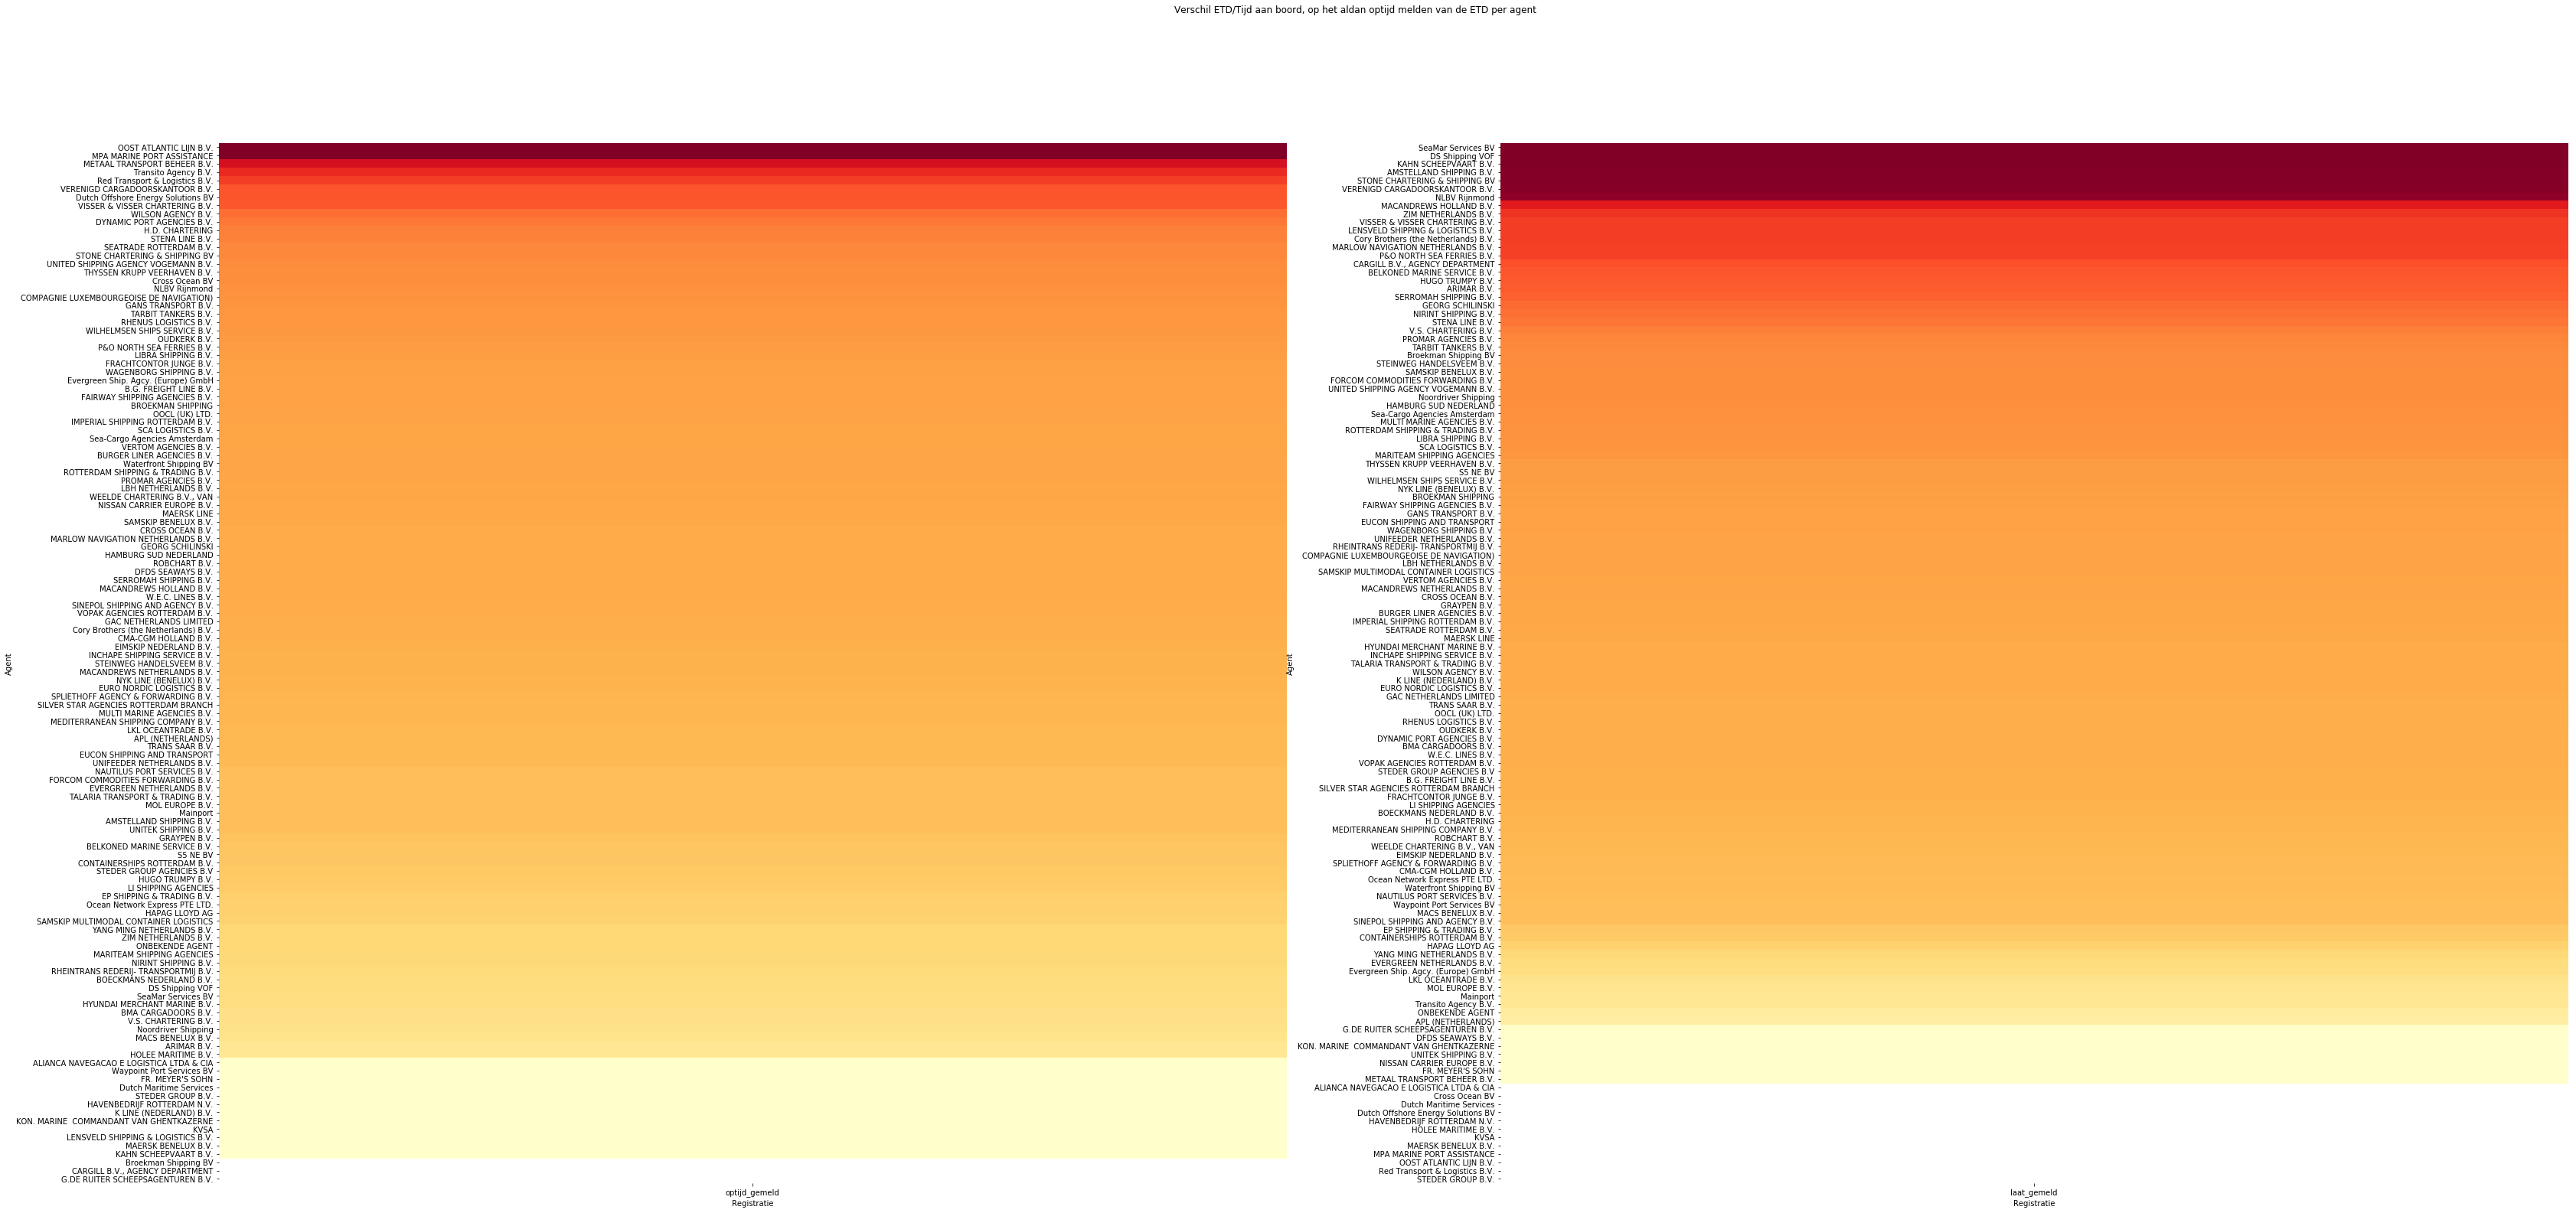

In [13]:
# import seaborn
import seaborn as sns

# heatmap voor soort schip
heatmap_data                    = pd.pivot_table(data, values = 'diff_tijdab_etd', index = ['Agent'], columns = 'Registratie')
# Sorteer waarden en maak verschillende groepen, optijd en laat gemeld
op_tijd                         = heatmap_data.drop(['laat_gemeld'], axis = 1)
op_tijd.sort_values(by          = ['optijd_gemeld'], inplace = True, ascending = False)

laat                            = heatmap_data.drop(['optijd_gemeld'], axis = 1)
laat.sort_values(by             = ['laat_gemeld'], inplace = True, ascending = False)

# Maak dubbele plot
fig, axes                       = plt.subplots(nrows=1, ncols=2, figsize=(55, 25))

# heatmap 1
sns.heatmap(op_tijd, cmap       = 'YlOrRd', ax = axes[0], cbar = False)

# heatmap 2
sns.heatmap(laat, cmap          = 'YlOrRd', ax = axes[1], cbar = False)
fig.suptitle('Verschil ETD/Tijd aan boord, op het aldan optijd melden van de ETD per agent')

*Laat gemelde reizen onder agenten (rechter visualisatie), hebben net wat vaker een hoog verschil tussen de ETD en de tijd aan boord (donkerrood) dan op tijd gemelde reizen onder agenten (linker visualisatie).* 

*Ook valt te verwachten dat wanneer een agent meer updates verstuurd, deze betrouwbaardere informatie opleverd, waardoor het verschil tussen de ETD en tijd aan boord ook minder groot zal zijn. Hier lijkt geen verband in te zitten aan de hand van de onderstaande heatmap:*

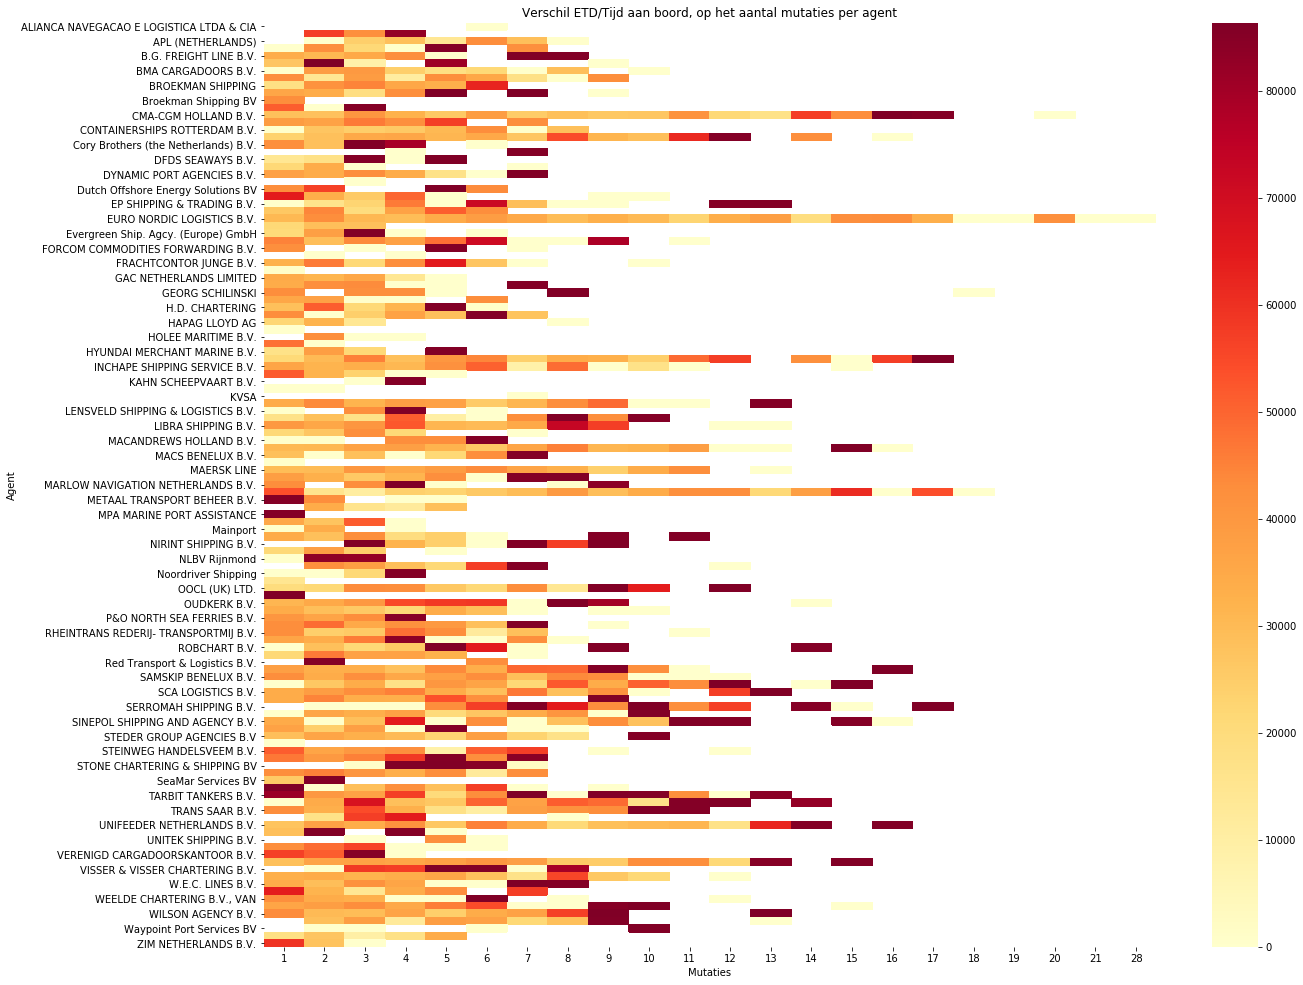

In [14]:
# import seaborn
import seaborn as sns

# heatmap voor soort schip
heatmap_data2                    = pd.pivot_table(data, values = 'diff_tijdab_etd', index = ['Agent'], 
                                                  columns = 'Mutaties')

# heatmap
plt.figure(figsize=(20, 17))
plt.title('Verschil ETD/Tijd aan boord, op het aantal mutaties per agent')
sns.heatmap(heatmap_data2, cmap  = 'YlOrRd');

In bovenstaande visualisatie is te zien, dat agenten niet minder verschil tussen de ETD en tijd aan boord ervaren, als ze vaker de ETD-tijd veranderen. 

*Wel lijkt het erop dat naarmate er meer mutaties plaatsvonden, het verschil tussen de op tijd gemelde en laat gemelde reizen kleiner wordt. Alhoewel, op tijd gemeld nooit laat gemeld overtreft. Naarmate het aantal mutaties toeneemt vindt er meer vertraging plaats in verhouden tot niet vertraagd. Zie inderstaande plots:*

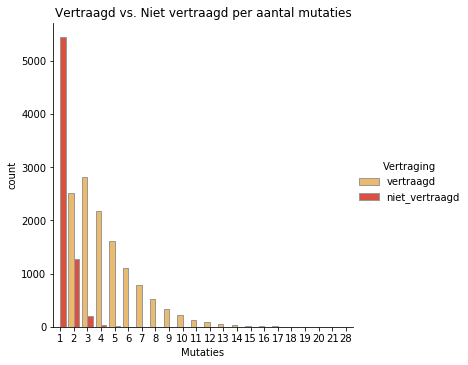

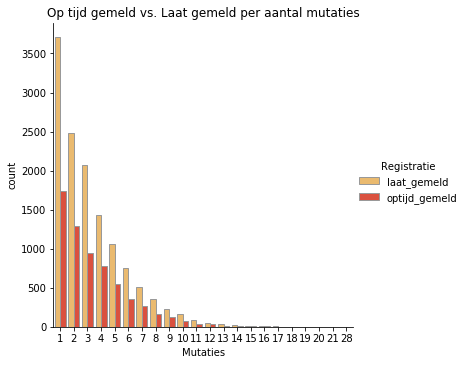

In [15]:
import seaborn as sns 

# eerste plot
sns.catplot(x = "Mutaties", kind = "count", hue = "Vertraging", edgecolor=".6", palette='YlOrRd', data = data)
plt.title('Vertraagd vs. Niet vertraagd per aantal mutaties')

# tweede plot
sns.catplot(x = "Mutaties", kind = "count", hue = "Registratie", edgecolor=".6", palette='YlOrRd', data = data)
plt.title('Op tijd gemeld vs. Laat gemeld per aantal mutaties')

plt.show();

### **Categorische + Continue variabelen:**

*Gezien het grote aantal onafhankelijke variabelen, zullen we opzoek moeten naar een regressie methode die de "onbelangrijke" variabelen kan verwijderen ofwel de coëfficiënten kan verkleinen naar 0, dit maakt de uitkomst ook beter te interpreteren. Hiervoor gaan we Lasso regressie gebruiken.*

*Om te beginnen gaan we opzoek naar de beste coëfficiënt:*

In [16]:
from sklearn.linear_model import Lasso
from sklearn.model_selection import GridSearchCV

# De afhankelijke variabele
y                                = tot['Mutaties']

# De onafhankelijke variabelen
X                                = tot.drop(['Mutaties', 'Reisnummer', 'Registratietijd', 'ETD', 'Tijd aan boord', 
                                            'Soort schip', 'Aankomst/vertreklocatie', 'Agent', 'Vertraging', 'Registratie',
                                            'Soort reis'], axis = 1)

# Split de data in train en test data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

lasso                            = Lasso()

parameters                       = {'alpha': [1e-15, 1e-10, 1e-8, 1e-4, 1e-3, 1e-2, 1, 5, 10, 20]}

lasso_regressor                  = GridSearchCV(lasso, parameters, cv = 5, n_jobs = -1)

lasso_regressor.fit(X_train, y_train)

print(lasso_regressor.best_params_)
print(lasso_regressor.best_score_)

{'alpha': 0.001}
0.8837126083567238


### **Lasso Regressie:**

In [17]:
from sklearn import linear_model

# De afhankelijke variabele
y                                = tot['Mutaties']

# De onafhankelijke variabelen
X                                = tot.drop(['Mutaties', 'Reisnummer', 'Registratietijd', 'ETD', 'Tijd aan boord', 
                                            'Soort schip', 'Aankomst/vertreklocatie', 'Agent', 'Vertraging', 'Registratie',
                                            'Soort reis'], axis = 1)

# Split de data in train en test data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

# Lasso model
clf                              = linear_model.Lasso(alpha = 0.001)

clf.fit(X_train, y_train)

y_pred                           = clf.predict(X_test)

# Haal de coefficienten op
coeff_df                         = pd.DataFrame(clf.coef_, X_test.columns, columns = ['Coefficient']) 

# Eens kijken welke variabelen daarbij horen
var                              = X.iloc[:, [0, 1, 2, 3, 8, 17, 18, 20, 22, 39, 51, 76, 83, 86, 105, 202, 252, 264, 405, 515, 592, 655, 656, 
                                              736, 860, 903, 908, 911, 913, 914, 922, 925, 933, 936, 944, 945, 952, 953, 956, 959, 
                                              962, 977, 978, 982, 986, 988, 989, 990, 991, 993, 995, 997, 998, 1002, 1005, 1007, 1012, 1014, 
                                              1024, 1025]]
features                         = list(var.columns)
importance                       = clf.sparse_coef_[0]
arr                              = importance[0, :].toarray()
res                              = arr[arr != 0]

# haal de coefficienten op
feature_imp                      = pd.Series(res, index = features).sort_values(ascending = False)

print('R-squared totaal model:', metrics.r2_score(y_test, y_pred))

print(feature_imp.head())

R-squared totaal model: 0.8892723081353704
agent_SERROMAH SHIPPING B.V.                    0.690044
schip_Pontoon (Functi                           0.481124
agent_SAMSKIP MULTIMODAL CONTAINER LOGISTICS    0.462270
agent_TALARIA TRANSPORT & TRADING B.V.          0.347007
agent_IMPERIAL SHIPPING ROTTERDAM B.V.          0.333133
dtype: float64


*Met Lasso Regressie behalen we een R-squared van 89%, dit betekent dat 89% van de variantie in het aantal mutaties verklaard kan worden aan de hand van de (59) overgebleven variabelen na Lasso. De belangrijkste 40 worden onderstaand gevisualiseerd:*

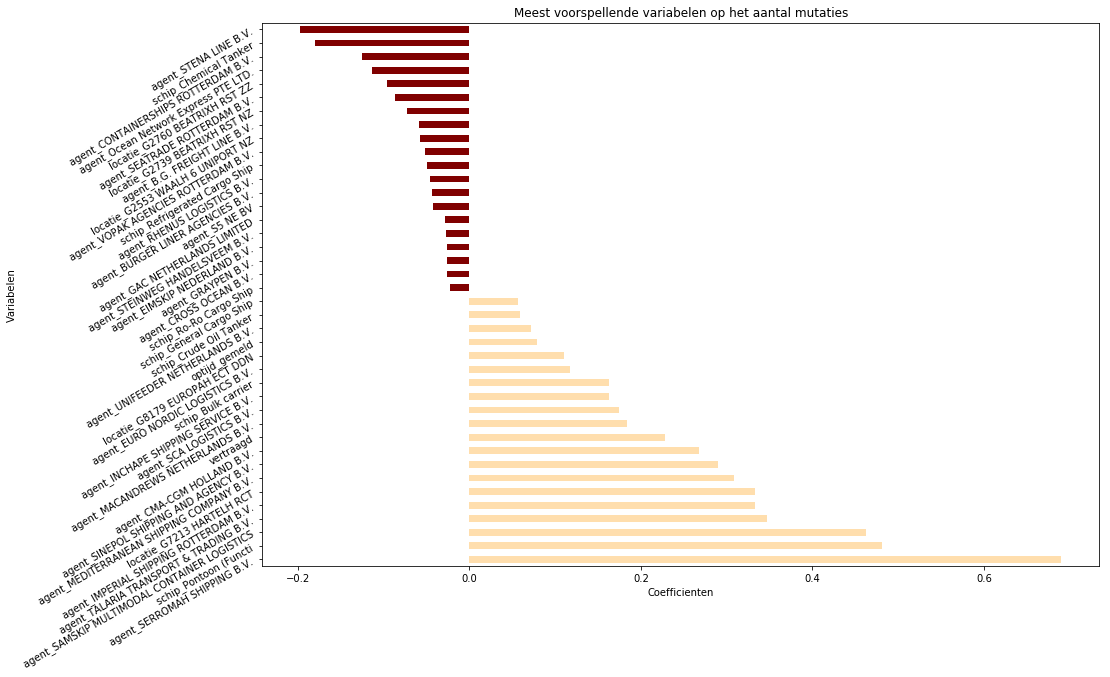

In [18]:
# selecteer de hoogste en laagste coefficienten
groot                = feature_imp.nlargest(n = 20).to_frame()
klein                = feature_imp.nsmallest(n = 20).to_frame()
klein                = klein.sort_values(by = 0, ascending=False)
frames               = [groot, klein]
totaal               = pd.concat(frames)

# Rownames naar kolom
totaal.index.name    = 'features'
totaal.reset_index(inplace=True)

# verander naam naar coefficient
totaal               = totaal.rename(columns = {0: "coefficient"})


import matplotlib.pyplot as plt
totaal['coefficient'].plot(kind = 'barh', color = (totaal['coefficient'] > 0).map({True: 'navajowhite', False: 'maroon'}),
                      figsize=(15,10))
plt.yticks(np.arange(40), totaal['features'], rotation=30)
plt.title('Meest voorspellende variabelen op het aantal mutaties')  
plt.xlabel('Coefficienten')  
plt.ylabel('Variabelen') 
plt.show()

*In de bovenstaande visualisatie kan je zien welke variabelen de grootste bijdragen hebben geleverd aan het model gebaseerd op de Lasso regressie, waarbij het aantal mutaties voorspeld werd aan de hand van alle variabelen in de data. Zo is bijvoorbeeld de agent SERROMAH SHIPPING B.V. zeer voorspellend voor een hoog aantal mutaties. Ook de variabele **optijd gemeld** heeft een positief verband met het aantal mutaties. Dit suggereerd, dat schepen die zich optijd registreren ook een groter aantal mutaties voorspellen. Ook, geeft de variabele **vertraagd** ook een positieve relatie met een aantal mutaties aan. Hoe groter het verschil tussen de eerste en laatste ETD, hoe meer mutaties plaats hebben gevonden (dit viel te verwachten). De negatieve variabelen, geven aan dat ze goed voorspellend zijn voor een laag aantal mutaties, zie bijvoorbeeld agent STENA LINE B.V.*

### *Decision Tree: Vertraging*

*Eerst eens kijken hoe vaak een schip vertraagd is, waarbij we alle enkele registraties uit de data laten:*

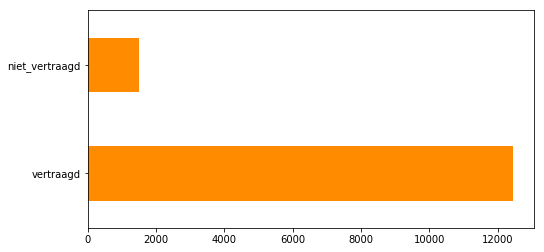

In [19]:
# Vetraging
import matplotlib.pyplot as plt
data       = data.loc[data['Mutaties'] > 1]
data['Vertraging'].value_counts().plot(kind='barh', figsize=(8,4), color = 'darkorange')
vertraging = tot

In [20]:
# Transformeer seconden naar uren
vertraging[['diff_tijdab_etd', 'reg_diff', 'etd_diff', 'diff_reg_etd']] = vertraging[['diff_tijdab_etd', 'reg_diff',
                                                                          'etd_diff', 'diff_reg_etd']].div(3600).round()

In [21]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

# De afhankelijke variabele
vertraging['vertraagd']                 = np.where(vertraging['vertraagd'] == 1, 'vertraagd', 'niet_vertraagd')
vertraging                              = vertraging.loc[tot['Mutaties'] > 1]
y                                       = vertraging['vertraagd']

# De onafhankelijke variabelen
X                                       = vertraging.drop(['Reisnummer', 'Registratietijd', 'ETD', 'Tijd aan boord', 
                                                           'Soort schip', 'Aankomst/vertreklocatie', 'Agent', 'Vertraging', 'Registratie',
                                                           'Soort reis', 'vertraagd', 'etd_diff'], axis = 1)

# Split de data in train en test data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 0)

# Decision tree
dtree                            = DecisionTreeClassifier(criterion = "entropy", max_depth = 3)
dtree.fit(X_train, y_train)

# Voorspelling
y_pred                           = dtree.predict(X_test)

# Model Accuracy
print("Accuracy decision tree:", metrics.accuracy_score(y_test, y_pred))

Accuracy decision tree: 0.9036877909058361


#### **Visualisatie Decision Tree**

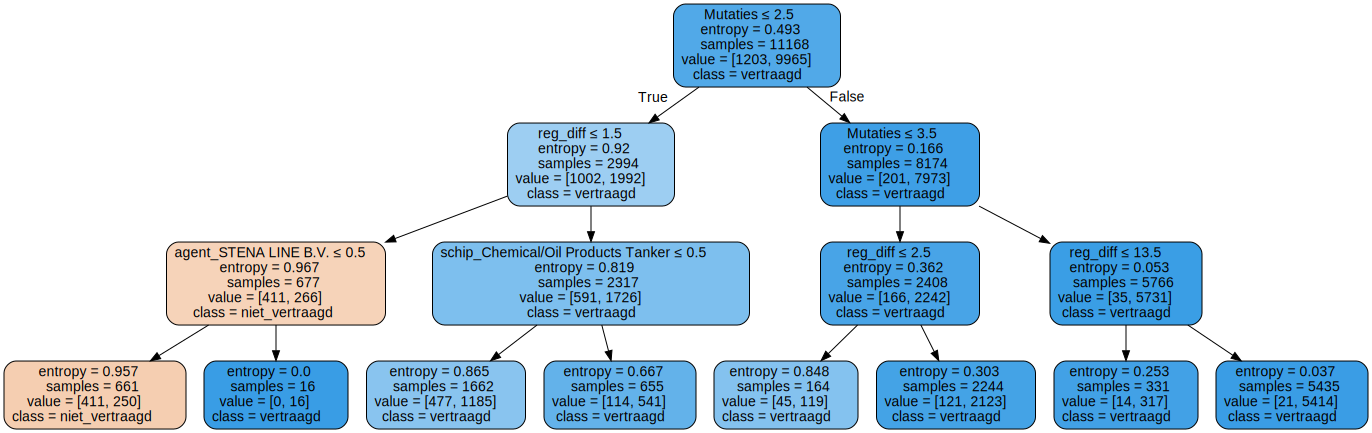

In [23]:
from sklearn.tree import export_graphviz
from sklearn.externals.six import StringIO  
from IPython.display import Image  
from sklearn import tree
import pydotplus
import graphviz 

# Maak visualisatie
feature_cols                    = list(X.columns)
class_n                         = dtree.classes_
dot_data                        = tree.export_graphviz(dtree, out_file = None, feature_names = feature_cols,  
                                  class_names = class_n, filled = True, rounded = True, special_characters = True)  
graph                           = graphviz.Source(dot_data)  
graph

**In deze beslisboom kunnen we het volgende observeren:**

- Als het **aantal mutaties** groter is dan 2.5 dan is de reis [vertraagd] (ETD-verschil is groter dan 2.5 uur).
- Als het **aantal mutaties** minder is dan 2.5 en het verschil in **registratietijd** kleiner is dan 1.5 uur, dan is de reis [niet vertraagd] (ETD-verschil is kleiner dan 2.5 uur).
- Als het **aantal mutaties** minder is dan 2.5 en het verschil in **registratietijd** groter is dan 1.5 uur, dan is de reis [vertraagd] (ETD-verschil is groter dan 2.5 uur).
- Als het **aantal mutaties** minder is dan 2.5, het verschil in **registratietijd** kleiner is dan 1.5 uur en de agent is **niet** STENA LINE B.V., dan is de reis [niet_vertraagd] (ETD-verschil is kleiner dan 2.5 uur).
- Hoe **donkerder** gekleurd het vakje, hoe zekerder de beslisboom is van de beslissing!


*Dat het aantal **mutaties** zo een grote bijdrage leveren aan deze belsisboom, valt te verklaren aan de hand van het feit dat er een zeer sterk correlatie is tussen het aantal mutaties en het ETD-verschil. Aangezien **vertraging** gebaseerd is op het ETD-verschil is er ook een sterk verband tussen het aantal mutaties en vertraging.*

### *Decision Tree: Registratie (Op tijd vs. Laat)*

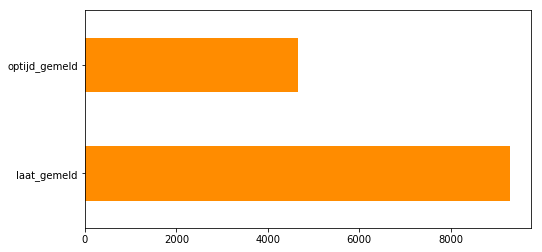

In [25]:
# Vetraging
import matplotlib.pyplot as plt
data = data.loc[data['Mutaties'] > 1]
data['Registratie'].value_counts().plot(kind='barh', figsize=(8,4), color = 'darkorange')
gemeld = tot

In [26]:
# Transformeer seconden naar uren
gemeld[['diff_tijdab_etd', 'reg_diff', 'etd_diff', 'diff_reg_etd']] = gemeld[['diff_tijdab_etd', 'reg_diff',
                                                                          'etd_diff', 'diff_reg_etd']].div(3600).round()

In [27]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

# De afhankelijke variabele
gemeld['optijd_gemeld']             = np.where(gemeld['optijd_gemeld'] == 1, 'optijd_gemeld', 'laat_gemeld')
y                                   = gemeld['optijd_gemeld']

# De onafhankelijke variabelen
X                                   = gemeld.drop(['Reisnummer', 'Registratietijd', 'ETD', 'Tijd aan boord', 
                                                   'Soort schip', 'Aankomst/vertreklocatie', 'Agent', 'Vertraging', 'Registratie',
                                                   'Soort reis', 'optijd_gemeld', 'diff_reg_etd'], axis = 1)

# Split de data in train en test data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 0)

# Decision tree
dtree                            = DecisionTreeClassifier(criterion = "entropy", max_depth = 3)
dtree.fit(X_train, y_train)

# Voorspelling
y_pred                           = dtree.predict(X_test)

# Model Accuracy
print("Accuracy decision tree:", metrics.accuracy_score(y_test, y_pred))

Accuracy decision tree: 0.6720372359470104


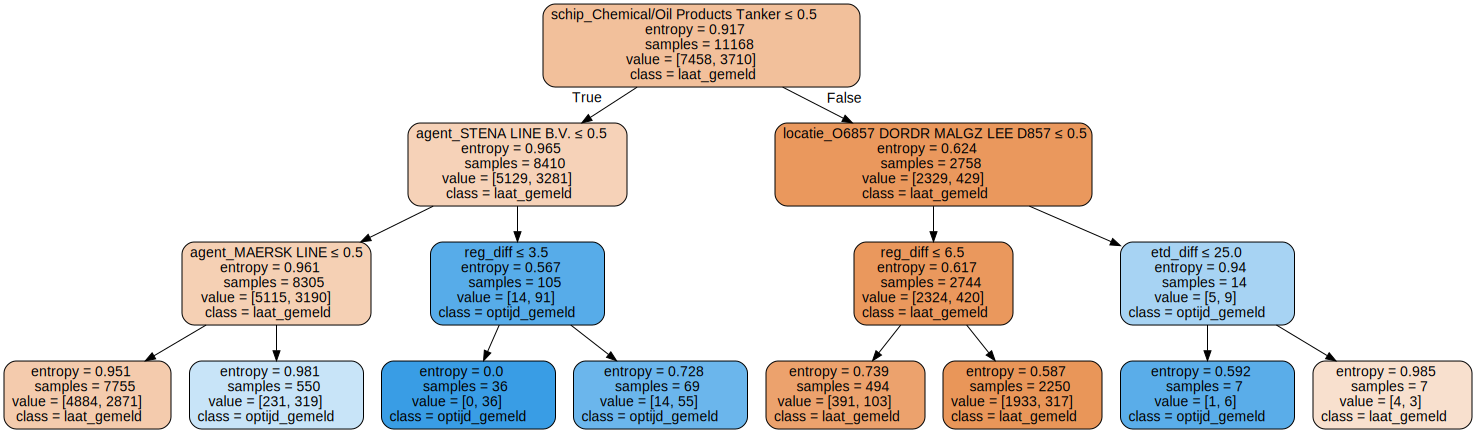

In [28]:
from sklearn.tree import export_graphviz
from sklearn.externals.six import StringIO  
from IPython.display import Image  
from sklearn import tree
import pydotplus
import graphviz 

# Maak visualisatie
feature_cols                    = list(X.columns)
class_n                         = dtree.classes_
dot_data                        = tree.export_graphviz(dtree, out_file = None, feature_names = feature_cols,  
                                  class_names = class_n, filled = True, rounded = True, special_characters = True)  
graph                           = graphviz.Source(dot_data)  
graph

**In deze beslisboom kunnen we het volgende observeren:**

Linker zijde beslisboom:
- Als het **soort schip** geen Chemical/Oil Products Tanker is en wel **agent** STENA LINE B.V is, dan is het schip [op tijd gemeld] (Verschil tussen registratie en ETD is groter dan 2.5).
- Als het **soort schip** geen Chemical/Oil Products Tanker is en niet **agent** STENA LINE B.V is, dan is het schip [laat gemeld] (Verschil tussen registratie en ETD is kleiner dan 2.5).
- Als het **soort schip** geen Chemical/Oil Products Tanker is, niet **agent** STENA LINE B.V is en wel **agent** MAERSK LINE is, dan is het schip [op tijd gemeld] (Verschil tussen registratie en ETD is groter dan 2.5).
- Als het **soort schip** geen Chemical/Oil Products Tanker is, niet **agent** STENA LINE B.V is en niet **agent** MAERSK LINE is, dan is het schip [laat gemeld] (Verschil tussen registratie en ETD is kleiner dan 2.5).
- Hoe **donkerder** gekleurd het vakje, hoe zekerder de beslisboom is van de beslissing!

Rechter zijde beslisboom:


- Als het **soort schip** wel Chemical/Oil Products Tanker is en de **locatie** is O6857 DORDR MALGZ LEE D857, dan is het schip [op tijd gemeld] (Verschil tussen registratie en ETD is groter dan 2.5)
- Als het **soort schip** wel Chemical/Oil Products Tanker is, de **locatie** is O6857 DORDR MALGZ LEE D857 en het **ETD-verschil** is groter dan 25 uur, dan is het schip [laat gemeld] (Verschil tussen registratie en ETD is kleiner dan 2.5).
- Als het **soort schip** wel Chemical/Oil Products Tanker is, de **locatie** is O6857 DORDR MALGZ LEE D857 en het **ETD-verschil** is kleiner dan 25 uur, dan is het schip [op tijd gemeld] (Verschil tussen registratie en ETD is groter dan 2.5).
- Als het **soort schip** wel Chemical/Oil Products Tanker is en de **locatie** is niet O6857 DORDR MALGZ LEE D857, dan is het schip [laat gemeld] (Verschil tussen registratie en ETD is kleiner dan 2.5).
- Hoe **donkerder** gekleurd het vakje, hoe zekerder de beslisboom is van de beslissing!